In [17]:
import os
import torch
torch.use_deterministic_algorithms(False)
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from feature.scalers import ranged_scaler
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')
from feature.engineering import *


from CARAT.model_utils import *
from CARAT.model import CausalGraphVAE

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows
from CARAT.components import *
from CARAT.model_utils import *
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

from utils.utils import set_seed
from utils.utils import logger

os.environ['CUBLAS_WORKSPACE_CONFIG'] = '167772160'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.backends.cudnn.benchmark=False
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)
torch.autograd.set_detect_anomaly(mode=False)
data = []
with open('data/TEP/idv1/y.dat', 'r') as file:
    for line in file:
        columns = line.strip().split("\t")
        new_cols = []
        for col in columns:
            new_cols.append(float(col.strip()))
        data.append(new_cols)

In [18]:
vars = len(data[0])
col_names = []
for i in  range(0,vars):
    col_names.append('x_'+str(i+1))
    

In [19]:
import polars as pl
from feature.scalers import ranged_scaler
df = pl.DataFrame(data,schema=col_names)
for col in df.columns:
    df = df.with_columns(ranged_scaler(df[col]))

In [20]:
df=df.to_pandas()

In [21]:
import seaborn as sns

In [22]:
df.shape[1]

51

In [23]:
df.shape

(301, 51)

In [24]:
start_date = '2023-03-01'  # Define the start date
date_range = pd.date_range(start=start_date, periods=df.shape[0])

In [25]:
n_lags = most_frequent(find_optimal_lags_for_dataframe(df))+1

In [26]:
df['time']=date_range

<Axes: xlabel='None', ylabel='x_44'>

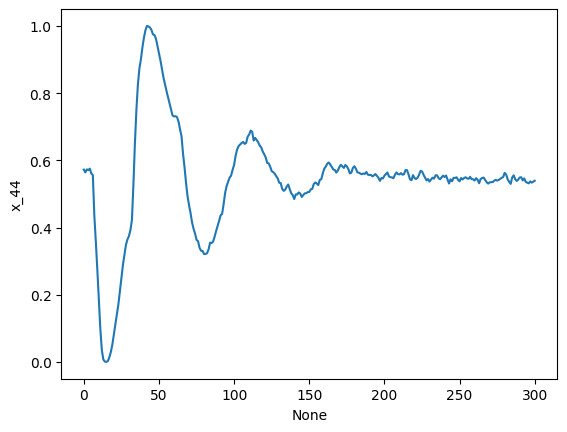

In [27]:
sns.lineplot(data=df,y='x_44',x=df.index)

In [28]:
device = torch.device("cuda:1")
#device = torch.device("cpu")

In [254]:
df = df[['x_1', 'x_4','x_7','x_13','x_16','x_16','x_18','x_19','x_44','x_50']]

In [255]:
normal = df[200:]
bad = df[0:200]

In [256]:
df.columns

Index(['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_16', 'x_18', 'x_19', 'x_44',
       'x_50'],
      dtype='object')

In [257]:
try:
    df = df.drop('time',axis=1)
except:
    None

try:
    normal = normal.drop('time',axis=1)
except:
    None
try:
    bad = bad.drop('time',axis=1)
except:
    None

In [258]:
df.shape

(301, 10)

In [259]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows
from CARAT.model_utils import *
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

class FourierTimeEmbedding(nn.Module):
    """Encodes time indices using sinusoidal embeddings for better temporal representation."""
    def __init__(self, embedding_dim,time_steps, max_time=100):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.max_time = max_time
        
        # Create frequency bands (log-spaced)
        self.freqs = torch.exp(torch.linspace(0, time_steps, embedding_dim//2,dtype=torch.float32)).to(device)

    def forward(self, time_indices):
        """
        Args:
            time_indices: Tensor of shape [batch_size, time_steps] containing integer time indices
        Returns:
            Embedded time representations of shape [batch_size, time_steps, embedding_dim]
        """
        time_indices = time_indices.unsqueeze(-1)  # Shape [batch_size, time_steps, 1]
        sinusoidal_in = time_indices * self.freqs  # Shape [batch_size, time_steps, embedding_dim//2]
        time_embedding = torch.cat([torch.sin(sinusoidal_in), torch.cos(sinusoidal_in)], dim=-1)
        return time_embedding  # Shape [batch_size, time_steps, embedding_dim]

class TemporalRealNVPFlow(nn.Module):
    """Time-Adaptive Normalizing Flow for Latent Confounders."""
    def __init__(self, latent_dim,input_dim):
        super().__init__()
        self.scale = nn.Linear(latent_dim // 2, latent_dim // 2,dtype=torch.float32)
        self.translate = nn.Linear(latent_dim // 2, latent_dim // 2,dtype=torch.float32)
        self.time_embedding = FourierTimeEmbedding(latent_dim,input_dim)
        self.temporal_gate = nn.GRU(latent_dim, latent_dim//2, batch_first=True,dtype=torch.float32)  # Time-aware updates
        self.time_projection = nn.Linear(input_dim,1,dtype=torch.float32)
    def forward(self, z, time_context):
        z1, z2 = z.chunk(2, dim=1)  # Split into two parts
        s = torch.sigmoid(self.scale(z1))
        t = self.translate(z1)
        z2 = s * z2 + t
        time_embed = self.time_embedding(time_context)
        # Temporal adjustment to confounders
        time_out, _ = self.temporal_gate(time_embed)
        time_out = self.time_projection(time_out.permute(0,2,1)).squeeze(2)
        z2 = z2 + time_out#.squeeze(1)  # Adjust for temporal shift
        
        return torch.cat([z1, z2], dim=1)

class TemporalCausalGraph(nn.Module):
    """
    Implements a Temporal Causal Graph (TCG) with:
    - Time-dependent adjacency matrix (instantaneous + delayed effects)
    - Adaptive normalizing flow for non-stationarity handling
    """
    def __init__(self, num_nodes, hidden_dim, latent_dim,time_steps=10, prior_adj=None, instantaneous_weight=0.5,lag_weight=0.5,mixed_data=False):
        super(TemporalCausalGraph, self).__init__()
        self.num_nodes = num_nodes
        self.latent_dim = latent_dim
        self.time_steps = time_steps
        self.instantaneous_weight=instantaneous_weight
        self.lag_weight=lag_weight
        self.mixed_data = mixed_data  # Support for categorical + continuous

        self.pos_embedding = nn.Embedding(time_steps, hidden_dim,dtype=torch.float32)

        # Learnable adjacency matrices (instantaneous + delayed)
        self.edge_score_now = nn.Parameter(torch.randn(num_nodes, num_nodes,device=device))
        #self.adj_mat = nn.Parameter(torch.randn(num_nodes, num_nodes,device=device))
        self.edge_score_lag = nn.Parameter(torch.randn(num_nodes, num_nodes,device=device))
        self.prior_adj = prior_adj if prior_adj is not None else torch.zeros(num_nodes, num_nodes,device=device)

        # Direct adjacency learning
        self.dropout = nn.Dropout(p=0.3)  # Dropout rate 30%
        self.x_projection1 = nn.Sequential(
            nn.Linear(num_nodes, hidden_dim, dtype=torch.float32),
            nn.ReLU(),
            self.dropout
        )
      
        self.self_attention = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim, dtype=torch.float32,dropout=0.2),
            num_layers=2
        )
        self.x_projection2 = nn.Linear(hidden_dim,num_nodes,dtype=torch.float32)

        # Latent Confounders Z (Time-Aware)
        
        self.temporal_flow = TemporalRealNVPFlow(latent_dim,time_steps)

        # Temporal Graph Attention Network
        self.gnn = GATv2Conv(num_nodes, hidden_dim, heads=4, concat=True, dropout=0.2).to(torch.float32)

        # Mapping from latent space to num_nodes
        self.latent_to_nodes = nn.Linear(latent_dim, num_nodes,dtype=torch.float32)

        # Likelihood Models
        self.gaussian_likelihood = nn.Sequential(
            nn.Dropout(0.2),  # Dropout before final layer
            nn.Linear(hidden_dim * 4, self.num_nodes*2, dtype=torch.float32)
        )  # Mean, Log-Variance
        if mixed_data:
            self.categorical_likelihood = nn.Linear(hidden_dim, num_nodes,dtype=torch.float32)  # Gumbel-Softmax Output

    def forward(self, X, time_context,Z):
        """ Learns causal graph over time and performs inference """
        # Compute adjacency matrices
        x = self.x_projection1(X)
        pos_indices = torch.arange(self.time_steps, device=X.device)  # [time_steps]
        X_permuted = x.permute(1, 0, 2)  # [time_steps, batch_size, num_nodes]
        pos_embedding = self.pos_embedding(pos_indices).unsqueeze(1) 
        
        X_transformed = self.self_attention(X_permuted + pos_embedding)
        x = self.x_projection2(X_transformed)


        weights_schedule = generate_decreasing_weights(3,start=0.2)
        lag_mats = []
        for i in range(0,x.shape[0]):
            if i ==0:
                lag_mats.append( replace_zero(torch.sigmoid(self.edge_score_now* weights_schedule[i])  +self.prior_adj + F.normalize(F.gumbel_softmax(torch.einsum('bk,bj->kj', x[i,:,:], x[i,:,:]) * weights_schedule[i],tau=100,eps=1e-16,))).fill_diagonal_(-1)) 
            else:
                lag_mats.append( replace_zero(torch.sigmoid(self.edge_score_lag* weights_schedule[i])  +self.prior_adj + F.normalize(F.gumbel_softmax(torch.einsum('bk,bj->kj', x[i,:,:], x[i,:,:]) * weights_schedule[i],tau=100,eps=1e-16,))).fill_diagonal_(-1)) 
        
        adj_now = torch.sigmoid(lag_mats[0] )  # Amplify signal
        if x.shape[0] >1:
            adj_lag = torch.sigmoid(torch.sum(torch.stack(lag_mats[1:]), dim=0))
        else:
            adj_lag = torch.sigmoid(lag_mats[1])
        self.adj_mat = adj_now * 0.3 + adj_lag * 0.7
       
        # Encode latent confounders with time-awareness
        #Z = self.latent_Z + torch.randn_like(self.latent_Z) * 0.1
        """Z = self.temporal_flow(Z.to(device), time_context.to(device))  # Apply time-adaptive normalizing flow
        Z = self.latent_to_nodes(Z)  # Map latent space to num_nodes

        # Temporal graph attention
        edge_index,edge_weights = dense_to_sparse( adj_mat)
        X_emb = self.gnn(Z, edge_index)
        X_emb = X_emb.view(X_emb.shape[0], -1)

        # Likelihood computation
        mean_logvar = self.gaussian_likelihood(X_emb)
        mean, log_var = torch.split(mean_logvar, mean_logvar.shape[-1] // 2, dim=-1)
        log_var = torch.clamp(log_var, -5, 2)  # Stabilization
        
        likelihood = Laplace(mean, torch.exp(0.5 * log_var))"""
        likelihood = 0
        
        return adj_now, adj_lag, likelihood

In [260]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows
#from CARAT.components import *
from CARAT.model_utils import *
import pandas as pd
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

class CausalGraphVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_nodes, time_steps=10, prior_adj=None,instantaneous_weight=0.5):
        super(CausalGraphVAE, self).__init__()
        self.instantaneous_weight = instantaneous_weight
        self.lag_weight = 1.0 - self.instantaneous_weight
        self.time_steps = time_steps
        self.num_nodes = num_nodes
        self.latent_dim = latent_dim
        self.prior_adj = prior_adj
        self.causal_graph = TemporalCausalGraph(num_nodes, hidden_dim, latent_dim, time_steps, prior_adj,self.instantaneous_weight,self.lag_weight)
        self.alpha = torch.tensor(0.0, dtype=torch.float32, requires_grad=False, device=device)
        self.rho = torch.tensor(1.0, dtype=torch.float32, requires_grad=False, device=device)

        # Temporal-aware Encoder and Decoder
        self.encoder_rnn = nn.GRU(input_dim, hidden_dim, batch_first=True,dtype=torch.float32, device=device)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim,dtype=torch.float32, device=device)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim,dtype=torch.float32, device=device)
        self.decoder_rnn = nn.GRU(latent_dim, hidden_dim, batch_first=True,dtype=torch.float32, device=device)
        self.decoder_fc = nn.Linear(hidden_dim, input_dim,dtype=torch.float32, device=device)

    def encode(self, X, time_context):
        X_enc, _ = self.encoder_rnn(X)
        mu, logvar = self.mu_layer(X_enc[:, -1, :]), self.logvar_layer(X_enc[:, -1, :])
        Z = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
        adj_now, adj_lag, likelihood = self.causal_graph(X, time_context,Z)  # Use temporal causal graph
        return mu, logvar, adj_now, adj_lag, likelihood

    def decode(self, Z, adj_now, adj_lag):
        Z_expanded = Z.unsqueeze(1).repeat(1, self.time_steps, 1)
        X_dec, _ = self.decoder_rnn(Z_expanded)
        X_dec = self.decoder_fc(X_dec)
        return X_dec

    def forward(self, X, time_context):
        X = X.to(torch.float32)  # Convert input X to float32
        time_context = time_context.to(torch.float32)  # Convert time context to float32

        mu, logvar, adj_now, adj_lag, likelihood = self.encode(X, time_context)
        Z = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
        recon_X = self.decode(Z, adj_now, adj_lag)
        return recon_X, mu, logvar, adj_now, adj_lag, likelihood

    def infer_causal_effect(self, X_data, T_data, target_variable, labels, non_causal_indices=[]):
        """Infers the top causal factors for a given target variable using counterfactual analysis."""
        
        try:
            target_idx = labels.index(target_variable, 0)
        except:
            return target_variable + " not in index"
    
        self.eval()
        n_samples = X_data.shape[0]
    
        with torch.no_grad():
            _, _, adj_now, adj_lag, _ = self.encode(X_data, T_data)
            adj_matrix = adj_now * self.instantaneous_weight + adj_lag * self.lag_weight
    
            # Compute edge strengths
            causal_strengths = adj_matrix[:, target_idx].cpu().detach().numpy()
            edge_strengths = {labels[i]: float(np.round(val.item(), 6)) for i, val in enumerate(causal_strengths) if i not in non_causal_indices}

            instantaneous_strengths = adj_now[:, target_idx].cpu().detach().numpy()
            instantaneous_edge_strengths = {}
            for i, val in enumerate(instantaneous_strengths):
                if i not in non_causal_indices:
                    instantaneous_edge_strengths[labels[i]] = float(np.round(val.item(),6))
            
            lagged_strengths = adj_lag[:, target_idx].cpu().detach().numpy()
            lagged_edge_strengths = {}
            for i, val in enumerate(lagged_strengths):
                if i not in non_causal_indices:
                    lagged_edge_strengths[labels[i]] = float(np.round(val.item(),6))

            
            counterfactual_results_positive = {}
            counterfactual_results_negative = {}
    
            for i in range(self.num_nodes):
                if i == target_idx or i in non_causal_indices:
                    continue
                
                label = labels[i]
    
                # Positive intervention: set cause variable to 1
                intervention_pos = X_data.clone()
                intervention_pos[:, :, i] = 1  
                mu, logvar, adj_now_int, adj_lag_int, likelihood = self.encode(intervention_pos, T_data)
                Z = mu + torch.randn_like(logvar, dtype=torch.float32, device=device) * torch.exp(0.5 * logvar)
                recon_X = self.decode(Z, adj_now_int, adj_lag_int)
    
                # Compute normalized deviation for positive intervention
                counterfactual_results_positive[label] = torch.abs((X_data[:, :, target_idx] - recon_X[:, :, target_idx]) / (X_data[:, :, target_idx] + 1e-6)).mean().item()
    
                # Negative intervention: set cause variable to -1
                intervention_neg = X_data.clone()
                intervention_neg[:, :, i] = -1
                mu, logvar, adj_now_int, adj_lag_int, likelihood = self.encode(intervention_neg, T_data)
                Z = mu + torch.randn_like(logvar, dtype=torch.float32, device=device) * torch.exp(0.5 * logvar)
                recon_X = self.decode(Z, adj_now_int, adj_lag_int)
    
                # Compute normalized deviation for negative intervention
                counterfactual_results_negative[label] = torch.abs((X_data[:, :, target_idx] - recon_X[:, :, target_idx]) / (X_data[:, :, target_idx] + 1e-6)).mean().item()
    
            # Compute composite counterfactual score
            counterfactual_rankings = {key: counterfactual_results_positive[key] + counterfactual_results_negative[key] for key in counterfactual_results_positive}
    
            # Sort by impact score
            sorted_keys = sorted(counterfactual_rankings, key=counterfactual_rankings.get, reverse=True)
            counterfactual_rankings = {key: counterfactual_rankings[key] for key in sorted_keys}
            sorted_keys = sorted(edge_strengths, key=edge_strengths.get, reverse=True)
            top_causes = {key: edge_strengths[key] for key in sorted_keys}
            sorted_keys = sorted(instantaneous_edge_strengths, key=instantaneous_edge_strengths.get, reverse=True)
            instantaneous_effects = {key: instantaneous_edge_strengths[key] for key in sorted_keys}
            sorted_keys = sorted(lagged_edge_strengths, key=lagged_edge_strengths.get, reverse=True)
            lagged_effects = {key: lagged_edge_strengths[key] for key in sorted_keys}
            
                
        return top_causes, counterfactual_rankings, instantaneous_effects, lagged_effects

    def loss_function(self, recon_X, X, mu, logvar, likelihood, adj_now, adj_lag, epoch, max_epochs, rho_max=30.0, alpha_max=15.0, lambda_prior=5.0):
        """Loss function including reconstruction, KL divergence, DAG penalty, and prior regularization"""
        recon_loss = F.mse_loss(recon_X, X, reduction='sum')
        beta = min(1.0, epoch / max_epochs)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
        # Regularization on adjacency matrix (pretrained `prior_adj` should remain mostly intact)
        #prior_loss = lambda_prior * (torch.norm(adj_now - self.prior_adj, p=1) + torch.norm(adj_lag - self.prior_adj, p=1))
    
        sparsity_loss = torch.norm(adj_now, p=1) * self.instantaneous_weight + torch.norm(adj_lag, p=1) * self.lag_weight
        h_value = (notears_constraint(adj_now) * self.instantaneous_weight + notears_constraint(adj_lag)) * self.lag_weight
    
        self.rho = min(rho_max, 1.0 + (epoch / max_epochs) ** 2 * 15.0)
        self.alpha = min(alpha_max, (epoch / max_epochs) ** 2 * 5.0)
    
        #likelihood_loss = (-likelihood.log_prob(X[:, 0, :]).mean()) + 5.0
        likelihood_loss = 0
    
        lagrangian_loss = (self.alpha * h_value + 0.5 * self.rho * (h_value ** 2)) / (self.num_nodes ** 2)


        return recon_loss , kl_loss , sparsity_loss , lagrangian_loss, likelihood_loss

    def train_model(self, dataloader, optimizer, num_epochs=100, patience=10,BATCH_SIZE=64,rho_max=30.0,alpha_max=15.0):
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(num_epochs):
            total_loss = 0
            for batch_idx, (X_batch, time_batch) in enumerate(dataloader):
                if X_batch.shape[0] < X_batch.shape[2]:
                    continue
                optimizer.zero_grad()
                recon_X, mu, logvar, adj_now, adj_lag, likelihood = self.forward(X_batch, time_batch)
                recon_loss , kl_loss , sparsity_loss , lagrangian_loss, likelihood_loss = self.loss_function(recon_X, X_batch, mu, logvar,likelihood, adj_now, 
                                                                                            adj_lag, epoch, num_epochs,rho_max,alpha_max)
                loss = recon_loss + kl_loss + sparsity_loss + lagrangian_loss # + likelihood_loss
                
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            self.adj_mat = scale_tensor(adj_now * 0.5 + adj_lag * 0.5)

            avg_loss = total_loss / len(dataloader)
            if epoch % 250 == 0:
                print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}")
                print(f"Recon Loss ={recon_loss:.4f}, KL Loss = {kl_loss:.4f}, Sparsity Loss = {sparsity_loss:.4f}, Lagrangian Loss = {lagrangian_loss:.4f}, Likelihood Loss = {likelihood_loss:.4f}") 

            
            # Early stopping
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered. Last Epoch: " + str(epoch) )
                    print(f"Recon Loss ={recon_loss:.4f}, KL Loss = {kl_loss:.4f}, Sparsity Loss = {sparsity_loss:.4f}, Lagrangian Loss = {lagrangian_loss:.4f}, Likelihood Loss = {likelihood_loss:.4f}") 
                    break

In [261]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from statsmodels.tsa.stattools import adfuller
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, time_steps=10):
        """
        Args:
            dataframe (pd.DataFrame): Time-series data
            time_steps (int): Number of past time steps to consider
        """
        self.data = torch.tensor(dataframe.values, dtype=torch.float32)
        self.time_steps = time_steps
    
    def __len__(self):
        return len(self.data) - self.time_steps

    def __getitem__(self, idx):
        """
        Returns:
            X: Past `time_steps` values (shape: [time_steps, num_features])
            y: Next step prediction target (shape: [num_features])
        """
        X = self.data[idx : idx + self.time_steps, :].to(device)
        time_context = torch.arange(self.time_steps).float().to(device)  # Time indexing
        
        return X, time_context

# Pretraining

In [262]:
TIME_STEPS = 2
BATCH_SIZE = 100
hidden_dim = 256
latent_dim = 16
device = torch.device("cuda:1")
num_nodes = normal.shape[1]

dataset_nominal = TimeSeriesDataset(normal, time_steps=TIME_STEPS)
dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model and optimizer
model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1],
                        time_steps=TIME_STEPS, prior_adj=None).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-2)

# Train on nominal data
print("Pretraining on nominal data...")
model.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=15.0,alpha_max=7.5)

# Extract learned adjacency
prior_adj = model.causal_graph.adj_mat.clone().detach()


Pretraining on nominal data...
Epoch 1: Loss = 727.5625
Recon Loss =645.4929, KL Loss = 0.0013, Sparsity Loss = 65.0874, Lagrangian Loss = 16.9809, Likelihood Loss = 0.0000
Early stopping triggered. Last Epoch: 70
Recon Loss =1.5552, KL Loss = 0.3621, Sparsity Loss = 59.1413, Lagrangian Loss = 7.1255, Likelihood Loss = 0.0000


In [263]:
device = torch.device("cuda:1")
num_nodes = normal.shape[1]

dataset_nominal = TimeSeriesDataset(bad, time_steps=TIME_STEPS)
dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model and optimizer
model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1],
                        time_steps=TIME_STEPS, prior_adj=prior_adj).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-2)

# Train on nominal data
print("Pretraining on nominal data...")
model.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=15.0,alpha_max=7.5)




Pretraining on nominal data...
Epoch 1: Loss = 926.0186
Recon Loss =459.7557, KL Loss = 0.0387, Sparsity Loss = 73.0728, Lagrangian Loss = 180.9227, Likelihood Loss = 0.0000
Early stopping triggered. Last Epoch: 62
Recon Loss =2.7037, KL Loss = 2.1387, Sparsity Loss = 70.0980, Lagrangian Loss = 139.5616, Likelihood Loss = 0.0000


In [264]:
X_data = torch.empty(0,device=device)
T_data = torch.empty(0,device=device)
for batch_idx, (X_batch, time_batch) in enumerate(dataloader_nominal):
    X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
    T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))

In [265]:
cols = list(df.columns)


In [281]:
causes, counterfactual_rankings, instantaneous_effects, lagged_effects = model.infer_causal_effect(X_data,
                                                                                                        T_data,
                                                                                                        'x_4',cols,non_causal_indices=[])

In [283]:
counterfactual_rankings

{'x_1': 2651.6332397460938,
 'x_19': 1386.855224609375,
 'x_44': 1379.7844848632812,
 'x_7': 844.6034240722656,
 'x_50': 822.5376892089844,
 'x_16': 802.9005432128906,
 'x_13': 753.3441467285156,
 'x_18': 729.6035614013672}

In [276]:
counterfactual_rankings

{'x_1': 2678.7144165039062,
 'x_19': 1437.0501403808594,
 'x_44': 1400.6938171386719,
 'x_16': 890.1227111816406,
 'x_7': 832.497802734375,
 'x_50': 814.3074035644531,
 'x_13': 803.5800170898438,
 'x_18': 710.6003570556641}

In [277]:
causes, counterfactual_rankings, instantaneous_effects, lagged_effects = model.infer_causal_effect(X_data,
                                                                                                        T_data,
                                                                                                        'x_16',cols,non_causal_indices=[])

In [279]:
causes

{'x_4': 0.737138,
 'x_19': 0.736559,
 'x_50': 0.736508,
 'x_7': 0.734815,
 'x_44': 0.731417,
 'x_16': 0.726542,
 'x_1': 0.722728,
 'x_13': 0.719871,
 'x_18': 0.712001}